# Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import gc

# Connection to drive

In [2]:
try:
    from google.colab import drive
    IN_COLAB = True
    print("Running on Google Colab. ")
except:
    IN_COLAB = False
    print("Not running on Google Colab. ")

Not running on Google Colab. 


In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

In [4]:
if IN_COLAB:
    os.chdir('/content/gdrive/MyDrive/Tesi/dataset')
else:
    os.chdir('./dataset')

# Downloading, Reading and Merging Data

In [5]:
def move_directories(orig_path, dest_path):
    # Check if the destination folder exists, otherwise create it
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)
    
    # Iter over all files and folders in the source directory
    for item in os.listdir(orig_path):
        orig_item_path = os.path.join(orig_path, item)
        
        # Check if it is a folder
        if os.path.isdir(orig_item_path):
            # Defines the destination path for the folder
            dest_item_path = os.path.join(dest_path, item)
            
            # Move the folder by renaming it
            os.rename(orig_item_path, dest_item_path)
            print(f"Moved directory: {orig_item_path} -> {dest_item_path}")

In [6]:
import kagglehub

# Check if some subdirectories are not empty
path_to_check = "./LUFlow/"
subdirs = [d for d in os.listdir(path_to_check) if os.path.isdir(os.path.join(path_to_check, d))]
non_empty_subdirs = [d for d in subdirs if os.listdir(os.path.join(path_to_check, d))]

dest_path = './LUFlow'

if non_empty_subdirs:
    print("Non-empty subdirectories:", non_empty_subdirs)
    print("Skip downloading.")
else:
    print("All subdirectories are empty.")
    print("Download dataset.")

    # Download latest version
    path = kagglehub.dataset_download("mryanm/luflow-network-intrusion-detection-data-set")

    print("Path to dataset files:", path)

    move_directories(path, dest_path)

Non-empty subdirectories: ['GranuleData', '2021', '2020', '2022', 'GranulatedData_300_complete', 'GranulatedData_32']
Skip downloading.


/home/ubdeskiovaro/anaconda3/envs/thesis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
encoded_dataset = './LUFlow/encoded_dataset.csv'

if os.path.isfile(encoded_dataset):
    print("Encoded dataset is in the directory.")
    ENCODED = True
else:
    print("Encoded dataset is not in the directory.")
    ENCODED = False

Encoded dataset is in the directory.


In [8]:
if not ENCODED:

    df_list = []
    i = 0

    selected_columns = ['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto', 'time_start', 'label']
    dtype_dict = {'bytes_in': np.int32, 'bytes_out': np.int32, 'num_pkts_out': np.int32, 
                  'num_pkts_in': np.int32, 'proto': np.int32, 'time_start': np.int64, 'label': str}

    for root, dirs, files in os.walk(dest_path):
        for file in files:
            # checks if 'file' does not exist in the directory
            # checks if 'csv' is in the file name
            # checks if a particular string is in the file name
            if not os.path.isfile(file) and 'csv' in file:
                chunk_iter = pd.read_csv(os.path.join(root, file), chunksize=10000, usecols=selected_columns, dtype=dtype_dict)
                for chunk in chunk_iter:
                    df_list.append(chunk)
                
                del chunk_iter
                gc.collect()
                i += 1

    df = pd.concat(df_list, ignore_index=True)

    del df_list
    gc.collect()

In [9]:
sorted_dataset = './LUFlow/sorted_encoded_dataset.csv'

if os.path.isfile(sorted_dataset) and ENCODED:
    print("Sorted dataset is in the directory.")
elif ENCODED:
    print("Sorting dataset.")

    dataset_encoded = pd.read_csv(encoded_dataset)
    dataset_encoded_sorted = dataset_encoded.sort_values(by=['time_start'])

    dataset_encoded_sorted.to_csv(sorted_dataset, index=False)

Sorted dataset is in the directory.


In [10]:
QUART = True

subset = 300

if ENCODED and QUART:
    import pandas as pd

    # Count number of lines in the file
    with open(sorted_dataset) as f:
        total_rows = sum(1 for _ in f) - 1  # exclude header

    # Compute the fraction
    n_quarter_rows = total_rows // subset

    # Load only first quarter of the dataset
    df = pd.read_csv(sorted_dataset, nrows=n_quarter_rows)

# Exploratory Data Analysis

In [11]:
import matplotlib.pyplot as plt

if not ENCODED:
    # Count the occurrences of each label
    label_counts = df['label'].value_counts()

    plt.figure(figsize=(8, 8))
    plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(label_counts) / 100, p))

    # Show the plot
    plt.title('Distribution of Labels')
    plt.show()

# Data Preprocessing

In [12]:
df.dropna(axis=1, inplace = True)

missing_values = df.isnull().sum()
print(missing_values)

bytes_in        0
bytes_out       0
num_pkts_out    0
num_pkts_in     0
proto           0
time_start      0
label           0
dtype: int64


In [13]:
if not ENCODED:
    df = df[df['label'].isin(['benign', 'malicious'])].copy()

    df = df.reset_index(drop=True)

In [14]:
from sklearn.preprocessing import LabelEncoder

if not ENCODED:
    label_encoder = LabelEncoder()

    # Fit and transform the label column
    df['label'] = label_encoder.fit_transform(df['label'])

In [15]:
if not ENCODED:
    df.to_csv(encoded_dataset, index=False)

## Construction of Interval Information Granules

### Selecting index using time windows

In [16]:
perc = 0.8

rows_perc = int(len(df)*perc)

df_train = df.iloc[:rows_perc]

In [17]:
if os.path.exists('./LUFlow/GranulatedData'):
    GRANULATED = True
else:
    GRANULATED = False

In [18]:
from tqdm import tqdm

time_slices = [16, 128, 256, 1024, 2048, 3016]

if not GRANULATED:
  matching_indices_slices = {}

  time_start_values = df['time_start'].values
  n = time_start_values

  for ts in tqdm(time_slices):
    # maximum time limit of the granule
    limit = time_start_values[0] + ts

    # number of groups for time_slice
    num_group = 0
    group_dict = {num_group:[0]}

    for i in range(1, len(n)):
        # if the value of time_start is greater than limit then limit is updated and
        # it is initilized a new group otherwise the index of the row is added to group_dict
        if time_start_values[i] >= limit:
          limit = time_start_values[i] + ts
          num_group += 1

          group_dict[num_group] = [i]
        else:
          group_dict[num_group].append(i)
    
    matching_indices_slices[ts] = group_dict
    del group_dict
    gc.collect()

100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


### Drop Label column

In [19]:
# Separate features (X) and target variable (y)
X_train = df.loc[:, df.columns != 'label']
y_train = df['label']

del df
gc.collect()

0

### Creating interval information granules with both approach to compute time spent creating granules


In [20]:
import math
import time

columns = ['num_frames_clust', 'time_clust', 'num_frames_just', 'time_just']

if not GRANULATED:
  alpha = 2.0
  l = 10

  for time_slice in time_slices:
    
    df = pd.DataFrame(columns=columns)
    df.to_csv(f'../time_comparison_{time_slice}.csv', index=False)

    for group in tqdm(matching_indices_slices[time_slice]):

      group_indeces = matching_indices_slices[time_slice][group]

      group_data = X_train.iloc[group_indeces]

      N = len(group_data)

      if N == 1:
        continue
      
      stats = group_data['time_start'].agg(['min', 'max', 'mean'])
      y_min, y_max, m = stats['min'], stats['max'], stats['mean']

      y_max_rel = y_max - y_min

      m_rel = m - y_min

      delta_y = (y_max_rel - m_rel)/l

      V_b_opt, V_a_opt = float('-inf'), float('-inf')
      a_opt, b_opt = None, None

      for h in range(0, l):
        b_rel = m_rel+h*delta_y
        a_rel = m_rel-h*delta_y

        b = y_min + b_rel
        sp_b = math.exp(-alpha*abs(m_rel-b_rel))

        a = y_min + a_rel
        sp_a = math.exp(-alpha*abs(a_rel-m_rel))

        cov_b = ((group_data['time_start'] > m) & (group_data['time_start'] <= b)).sum() / N
        cov_a = ((group_data['time_start'] > a) & (group_data['time_start'] <= m)).sum() / N

        V_b = cov_b*sp_b
        V_a = cov_a*sp_a

        if V_a > V_a_opt:
          a_opt, V_a_opt = a, V_a

        if V_b > V_b_opt:
          b_opt, V_b_opt = b, V_b

      condition = (group_data['time_start'] > a_opt) & (group_data['time_start'] <= b_opt)
      filtered_granule = group_data[condition]

      if filtered_granule.empty:
        continue  

      selected_rows = y_train.iloc[filtered_granule.index]

      # Time spent by Justifiable Granularity
      start_just = time.time()
      if len(filtered_granule) == 1:
        row = filtered_granule[['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto']]
      else:
        row = filtered_granule[['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto']].sum()      
      row['time_start'] = filtered_granule['time_start'].iloc[0]
      row['label'] = selected_rows.mode().iloc[0]
      end_just = time.time()

      # Time spent by Clustering
      granule_data_y = y_train.loc[group_indeces]
      start_clust = time.time()
      row = group_data[['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto']].sum()
      row['time_start'] = group_data['time_start'].iloc[0]
      row['label'] = granule_data_y.mode().iloc[0]
      end_clust = time.time()

      # Compute the time spent for each method and save to csv
      time_spent_just = end_just - start_just
      time_spent_clust = end_clust - start_clust

      len_just = len(filtered_granule)
      len_clust = len(group_data)

      time_row = {'num_frames_clust': len_clust, 'time_clust': time_spent_clust, 'num_frames_just': len_just, 'time_just': time_spent_just}
      time_row = pd.DataFrame([time_row])
      time_row.to_csv(f'../time_comparison_{time_slice}.csv', mode='a', header=False, index=False)
      # print(time_row)

      del group_data, filtered_granule, selected_rows

100%|██████████| 472192/472192 [06:36<00:00, 1190.81it/s]


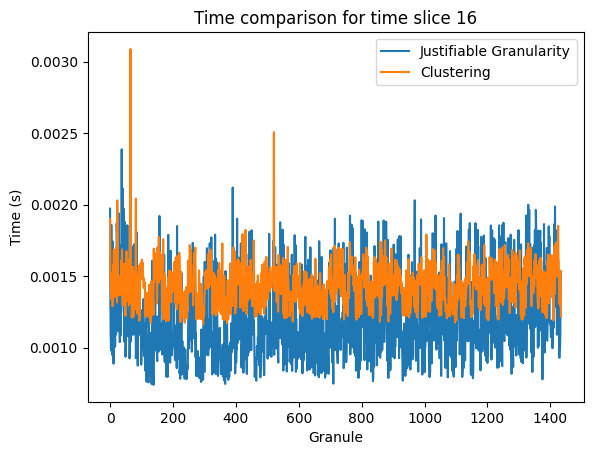

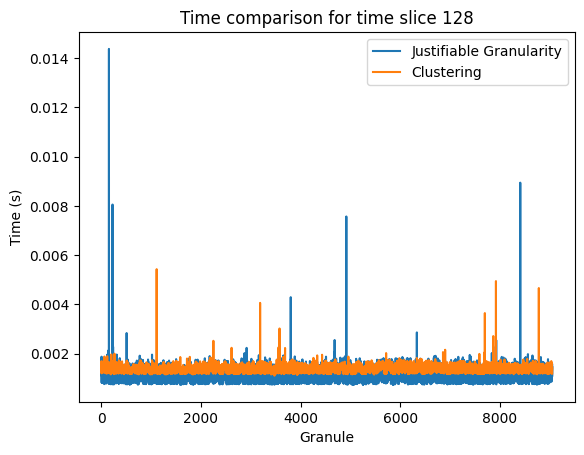

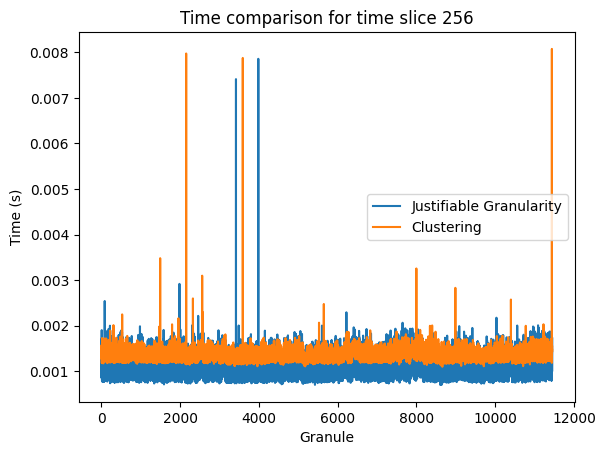

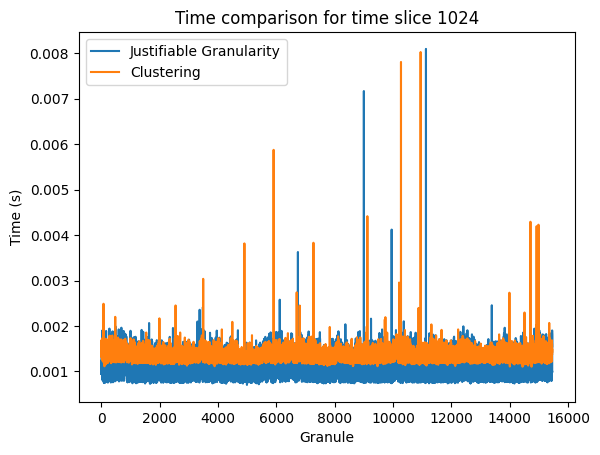

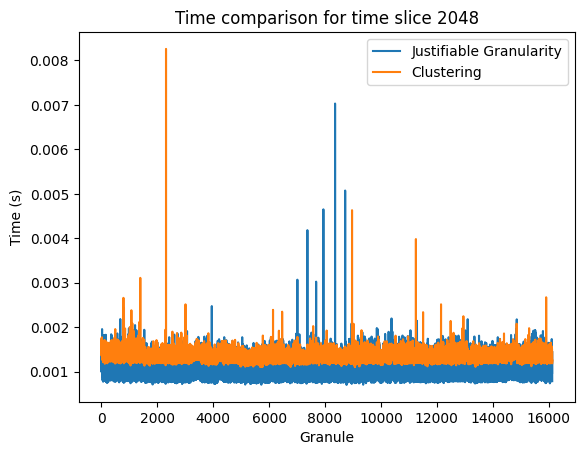

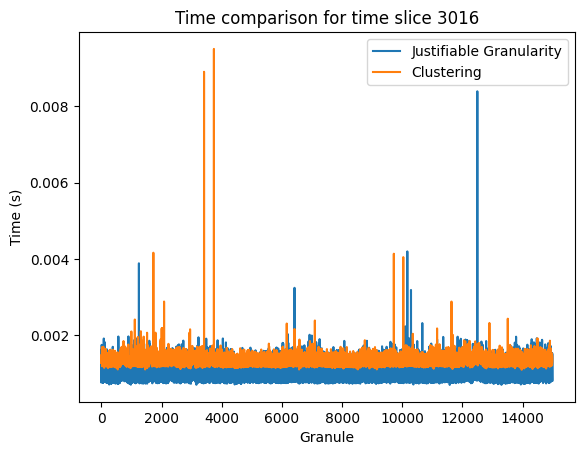

In [30]:
import matplotlib.pyplot as plt
import numpy as np

for time_slice in time_slices:
    df = pd.read_csv(f'../time_comparison_{time_slice}.csv')
    X_axis = np.arange(len(df))
    plt.plot(X_axis, df['time_just'], label='Justifiable Granularity')
    plt.plot(X_axis, df['time_clust'], label='Clustering')

    plt.xlabel('Granule')
    plt.ylabel('Time (s)')
    plt.title(f'Time comparison for time slice {time_slice}')
    plt.legend()
    plt.show()

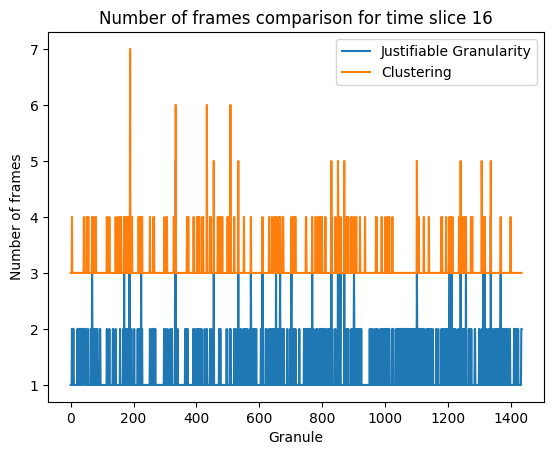

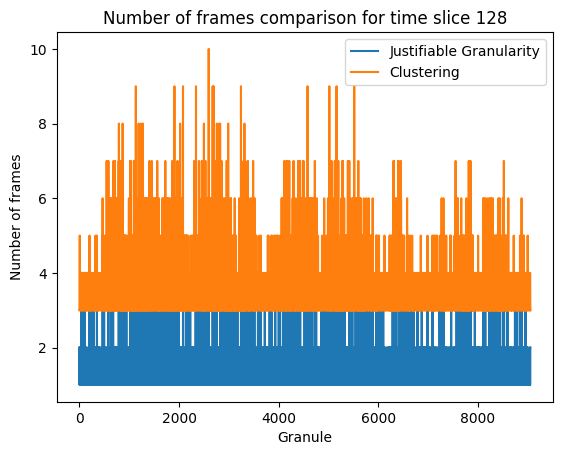

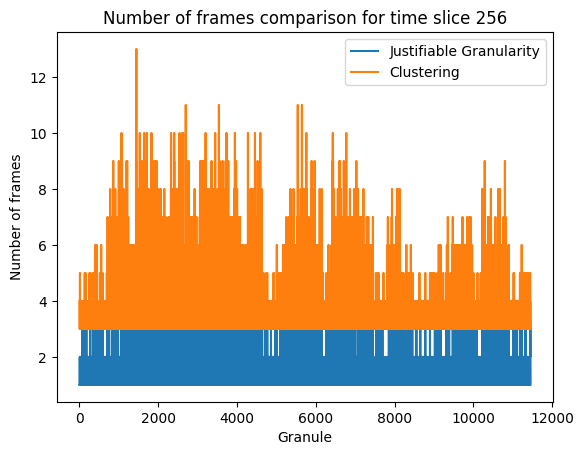

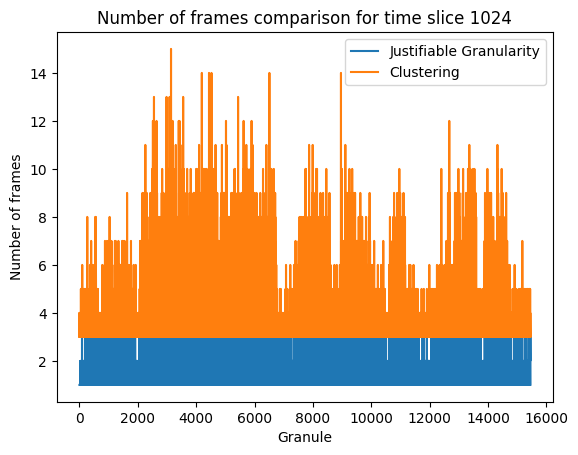

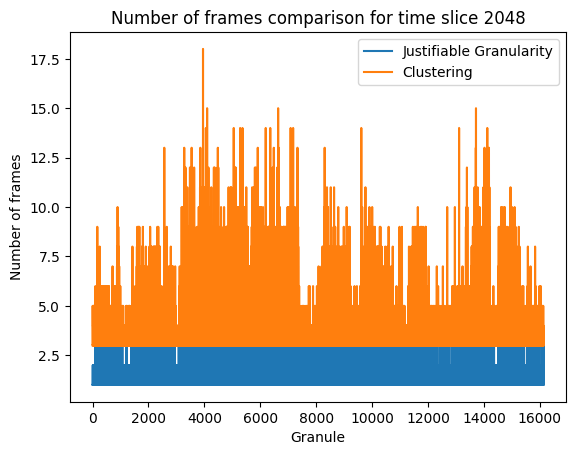

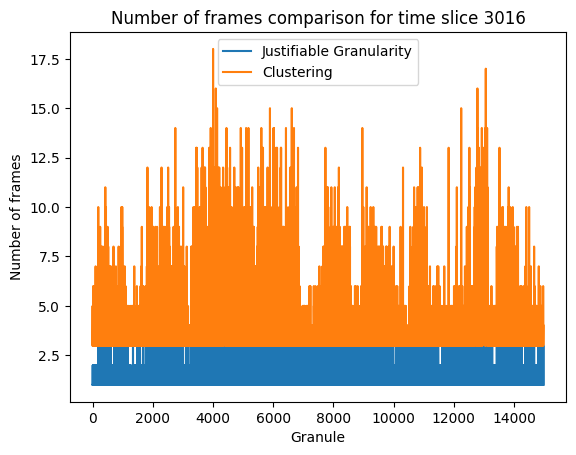

In [31]:
import matplotlib.pyplot as plt
import numpy as np

for time_slice in time_slices:
    df = pd.read_csv(f'../time_comparison_{time_slice}.csv')
    X_axis = np.arange(len(df))
    plt.plot(X_axis, df['num_frames_just'], label='Justifiable Granularity')
    plt.plot(X_axis, df['num_frames_clust'], label='Clustering')

    plt.xlabel('Granule')
    plt.ylabel('Number of frames')
    plt.title(f'Number of frames comparison for time slice {time_slice}')
    plt.legend()
    plt.show()